# Anomaly Detection & Recommender Systems

In [134]:
%matplotlib inline
import os
import numpy as np
import scipy.io as io
import scipy.linalg as la
import matplotlib.pyplot as plt
import scipy.optimize as optimize

## Anomaly detection

Here we will detect failing servers on a network.

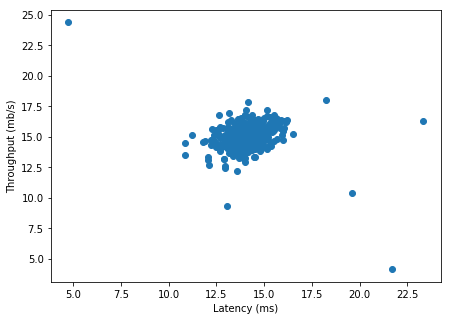

In [54]:
# Load and visualize data.
data = io.loadmat(os.path.join('data','ex8data1.mat'))
X = data['X']
Xval, yval = data['Xval'], data['yval'].ravel()
fig = plt.figure(figsize=(7, 5))
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.scatter(X[:, 0], X[:, 1])

In [48]:
# Fitting a Gaussian.
def estimate_gaussian(x):
    """
    Calculates the parameters for a Gaussian distribution,
    given a dataset, x.
    """
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    return mean, var

def multivariate_gaussian(x, mean, var):
    """
    Computes the probability density function of the 
    multivariate Gaussian distribution given a dataset, x, 
    and the associated mean and variance
    """
    m, n = x.shape
    if var.ndim == 1:
        var = np.diag(var)
    x = x - mean
    pdf = (np.exp(-0.5 * np.sum((x @ la.pinv(var)) * x, axis=1)) 
           / np.sqrt((2 * np.pi) ** n * la.det(var)))
    return pdf

In [57]:
mean, var = estimate_gaussian(X)
p = multivariate_gaussian(X, mean, var)

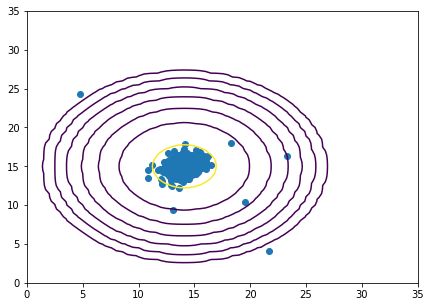

In [53]:
# Visualize fit
def plot_gaussian_contour(x, mean, var):
    """
    Plots Gaussian contour fits to the given dataset, x.
    """
    meshvals = np.arange(0, 35.5, 0.5)
    x1, x2 = np.meshgrid(meshvals, meshvals)
    z = multivariate_gaussian(np.stack([x1.ravel(), x2.ravel()], axis=1), mean, var)
    z = z.reshape(x1.shape)
    
    fig = plt.figure(figsize=(7, 5))
    plt.scatter(x[:, 0], x[:, 1])
    levels = 10 ** np.arange(-20., 1, 3)
    plt.contour(x1, x2, z, levels=levels, zorder=100)
    
plot_gaussian_contour(X, mean, var)

In [55]:
# Select threshold.
def select_threshold(pval, yval):
    """
    Selects the optimum threshold based on the F1 score of
    the validation data.
    ----
    pval: precomputed probability density of validation data.
    yval: ground truth of validation data
    """
    
    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    for epsilon in np.linspace(1.01 * min(pval), max(pval), 1000):
        false_neg = np.sum(np.logical_and(pval > epsilon, yval == 1))
        false_pos = np.sum(np.logical_and(pval < epsilon, yval == 0))
        true_pos = np.sum(np.logical_and(pval < epsilon, yval == 1))
        
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        
        F1 = 2 * precision * recall / (precision + recall)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
    
    return best_epsilon, best_F1

Best epsilon found using cross-validation set: 8.999852631901395e-05
Best F1 on cross-validation set: 0.8750000000000001


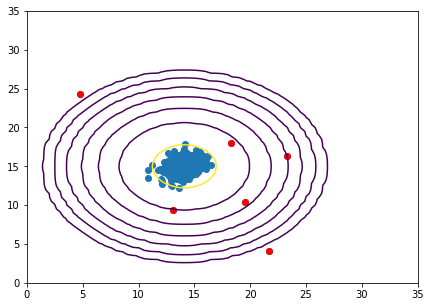

In [67]:
pval = multivariate_gaussian(Xval, mean, var)
epsilon, F1 = select_threshold(pval, yval)

print(f'Best epsilon found using cross-validation set: {epsilon}')
print(f'Best F1 on cross-validation set: {F1}')

outliers = p < epsilon
plot_gaussian_contour(X, mean, var)
plt.scatter(X[outliers, 0], X[outliers, 1], c='r')

### Anomaly detection with a realistic dataset

In [68]:
data = io.loadmat(os.path.join('data', 'ex8data2.mat'))
X, Xval, yval = data['X'], data['Xval'], data['yval'].ravel()

mean, var = estimate_gaussian(X)
p = multivariate_gaussian(X, mean, var)
pval = multivariate_gaussian(Xval, mean, var)

epsilon, F1 = select_threshold(pval, yval)
outliers = p < epsilon

In [69]:
print(f'Best epsilon found using cross-validation set: {epsilon}')
print(f'Best F1 on cross-validation set: {F1}')
print(f'Outliers found: {np.sum(outliers)}')

Best epsilon found using cross-validation set: 1.3786074987947624e-18
Best F1 on cross-validation set: 0.6153846153846154
Outliers found: 117


## Recommender Systems

In [46]:
# Load data.
data = io.loadmat(os.path.join('data', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

The average rating for the first movie is 3.9 / 5.


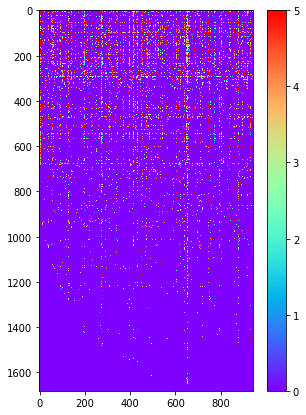

In [21]:
# Y contains the ratings of movies by users.
# R is a binary matrix that indicates if a user rated a movie.
print('The average rating for the first movie is %.1f / 5.'
      % np.mean(Y[0, R[0, :] == 1]))

# Visualize the ratings matrix.
fig = plt.figure(figsize=(5, 7))
plt.imshow(Y, cmap='rainbow')
plt.colorbar()

In [47]:
# Besides the Y and R matrices we will also use the X and Theta matrices, where
# the i-th row of X is the feature vector of the i-th movie in Y, and the j-th
# row of Theta is the one-parameter vector for the j-th user.
data_params = io.loadmat(os.path.join('data', 'ex8_movieParams.mat'))
X, Theta = data_params['X'], data_params['Theta']
num_users = data_params['num_users']
num_movies = data_params['num_movies']
num_features = data_params['num_features']

In [48]:
# For the present we will use a reduced feature set.
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [60]:
# Cost function.
def cf_cost_function(params, y, r, num_users, num_movies,
                     num_features, regulator=0):
    """
    Returns the cost function for collaborative filtering, and its gradient. 
    """
    # Unroll the parameters.
    x = params[:num_movies * num_features].reshape(num_movies, num_features)
    theta = params[num_movies * num_features:].reshape(num_users, num_features)

    # Non-regulated cost and gradient
    term1 = np.dot(x, theta.T) * r - y 
    cost = 0.5 * np.sum(term1 ** 2)
    x_grad = np.dot(term1, theta)
    theta_grad = np.dot(term1.T, x)

    # Regularization
    cost += 0.5 * regulator * np.sum(theta ** 2)
    cost += 0.5 * regulator * np.sum(x ** 2)
    x_grad += regulator * x
    theta_grad += regulator * theta

    grad = np.concatenate([x_grad.ravel(), theta_grad.ravel()])
    return cost, grad

In [62]:
flattened_params = np.concatenate([X.ravel(), Theta.ravel()])
cost, grad = cf_cost_function(flattened_params, Y, R,
                              num_users, num_movies, num_features)
print(f'Cost at loaded parameters: {cost}')

Cost at loaded parameters: 22.224603725685675


In [91]:
# Gradient checking.
def check_gradient(params, y, r, num_users, num_movies,
                   num_features, regulator=0):

    print('{:15} \t {:15} \t {:15}'.format(
        'CF gradient', 'Numerical gradient', 'Difference'))

    # Gradient from collaborative filter implementation.
    cf_cost, cf_grad = cf_cost_function(params, y, r, num_users,
                                        num_movies, num_features, regulator)

    # Numerical gradient.
    epsilon = 0.0001
    num_params = len(params)
    epsilon_vec = np.zeros(num_params)
    selection = np.random.randint(num_params, size=10)
    for i in selection:
        epsilon_vec[i] = epsilon
        cost1, grad1 = cf_cost_function(params + epsilon_vec, y, r, num_users,
                                        num_movies, num_features, regulator)
        cost2, grad2 = cf_cost_function(params - epsilon_vec, y, r, num_users,
                                        num_movies, num_features, regulator)
        numerical_grad = (cost1 - cost2) / epsilon / 2
        epsilon_vec[i] = 0
        grad_difference = cf_grad[i] - numerical_grad
        print('{:.15f} \t {:.15f} \t {:.03e}'.format(
            cf_grad[i], numerical_grad, grad_difference)) 

In [92]:
print('With lambda = 0')
check_gradient(flattened_params, Y, R, num_users, num_movies, num_features)
print('\n')
print('With lambda = 1.5')
check_gradient(flattened_params, Y, R, num_users, num_movies, num_features, 1.5)

With lambda = 0
CF gradient     	 Numerical gradient 	 Difference     
0.000000000000000 	 0.000000000000000 	 0.000e+00
7.575703079709334 	 7.575703079698570 	 1.076e-11
-0.523398454966595 	 -0.523398454959079 	 -7.516e-12
-0.353340482875070 	 -0.353340482881492 	 6.423e-12
4.627760190006159 	 4.627760190007990 	 -1.831e-12
2.263336983921972 	 2.263336983912012 	 9.960e-12
-7.160044429740945 	 -7.160044429745938 	 4.992e-12
-0.383582784622124 	 -0.383582784628800 	 6.676e-12
-0.353340482875070 	 -0.353340482881492 	 6.423e-12
-2.528991646082334 	 -2.528991646091328 	 8.994e-12


With lambda = 1.5
CF gradient     	 Numerical gradient 	 Difference     
0.296843952346254 	 0.296843952334314 	 1.194e-11
1.092897577688307 	 1.092897577699148 	 -1.084e-11
-2.293470242774885 	 -2.293470242769047 	 -5.838e-12
-6.765636277366184 	 -6.765636277386022 	 1.984e-11
-0.718206734196469 	 -0.718206734191540 	 -4.929e-12
-10.139854781302455 	 -10.139854781279212 	 -2.324e-11
0.482440977879083 	 0.4824

Thus the gradient checker confirms that the gradient implemented in `cf_cost_function` gives the expected result.

### Movie Recommendations

In [120]:
with open(os.path.join('data', 'movie_ids.txt'), encoding='ISO-8859-1') as f:
    movies = f.readlines()

movie_list = []
for movie in movies:
    parts = movie.split()
    movie_list.append(' '.join(parts[1:]).strip())

In [123]:
num_movies = len(movie_list) 
custom_ratings = np.zeros(num_movies)
selection = np.random.randint(num_movies, size=20)
for i in selection:
    custom_ratings[i] = np.random.randint(6)

In [124]:
print('Custom Ratings')
for i in range(num_movies):
    if custom_ratings[i] > 0:
        print('Rated {} stars {}'.format(custom_ratings[i], movie_list[i]))

Custom Ratings
Rated 1.0 stars Die Hard (1988)
Rated 1.0 stars 101 Dalmatians (1996)
Rated 4.0 stars FairyTale: A True Story (1997)
Rated 1.0 stars Blue Angel, The (Blaue Engel, Der) (1930)
Rated 4.0 stars Better Off Dead... (1985)
Rated 3.0 stars In the Bleak Midwinter (1995)
Rated 5.0 stars Halloween: The Curse of Michael Myers (1995)
Rated 5.0 stars Brassed Off (1996)
Rated 1.0 stars Renaissance Man (1994)
Rated 5.0 stars Mother Night (1996)
Rated 1.0 stars Party Girl (1995)
Rated 2.0 stars Hard Eight (1996)
Rated 4.0 stars Phat Beach (1996)
Rated 4.0 stars Saint of Fort Washington, The (1993)
Rated 1.0 stars Herbie Rides Again (1974)
Rated 2.0 stars Scream of Stone (Schrei aus Stein) (1991)


In [125]:
# Reload data and add custom ratings
data = io.loadmat(os.path.join('data', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']
Y = np.hstack([custom_ratings[:, None], Y])
R = np.hstack([custom_ratings[:, None], R])

In [143]:
# Normalize ratings.
def normalize_ratings(y, r):
    y_mean = np.sum(y, axis=1) / np.sum(r, axis=1)
    y_norm = y - y_mean[:, None]
    return y_norm, y_mean

Y_norm, Y_mean = normalize_ratings(Y, R)

In [136]:
# Parameters
num_movies, num_users = Y.shape
num_features = 10
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_params = np.concatenate([X.ravel(), Theta.ravel()])
regulator = 10

# Minimization
result = optimize.minimize(lambda x: cf_cost_function(x, Y_norm, R, num_users,
                                                      num_movies, num_features,
                                                      regulator),
                           initial_params,
                           method='TNC',
                           jac=True,
                           options={'maxiter': 100})
learned_params = result.x

In [137]:
# Unfold the learned parameters back into X and Theta.
X = learned_params[:num_movies * num_features].reshape(num_movies, num_features)
Theta = learned_params[num_movies * num_features:].reshape(num_users, num_features)

In [148]:
# Predictions
pred_mat = np.dot(X, Theta.T)
predictions = pred_mat[:, 0] + Y_mean

indices = np.argsort(predictions)[::-1]

print('Top recommendations for customer')
print('--------------------------------')
for i in range(10):
    j = indices[i]
    print('Predicting rating {:.1f} for movie {}'.format(
        predictions[j], movie_list[i]))

print('\n')
print('Original ratings provided')
print('-------------------------')
for i in range(len(custom_ratings)):
    if custom_ratings[i] > 0:
        print('Rated {} for {}'.format(custom_ratings[i], movie_list[i]))

Top recommendations for customer
--------------------------------
Predicting rating 10.7 for movie Toy Story (1995)
Predicting rating 10.5 for movie GoldenEye (1995)
Predicting rating 9.2 for movie Four Rooms (1995)
Predicting rating 9.1 for movie Get Shorty (1995)
Predicting rating 9.1 for movie Copycat (1995)
Predicting rating 8.8 for movie Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
Predicting rating 8.8 for movie Twelve Monkeys (1995)
Predicting rating 8.8 for movie Babe (1995)
Predicting rating 8.8 for movie Dead Man Walking (1995)
Predicting rating 8.7 for movie Richard III (1995)


Original ratings provided
-------------------------
Rated 1.0 for Die Hard (1988)
Rated 1.0 for 101 Dalmatians (1996)
Rated 4.0 for FairyTale: A True Story (1997)
Rated 1.0 for Blue Angel, The (Blaue Engel, Der) (1930)
Rated 4.0 for Better Off Dead... (1985)
Rated 3.0 for In the Bleak Midwinter (1995)
Rated 5.0 for Halloween: The Curse of Michael Myers (1995)
Rated 5.0 for Brassed Off (1996)
